# Forecasting III: multivariate, hierarchical

This tutorial covers multivariate and hierarchical time series modeling with the [pyro.contrib.forecast](http://docs.pyro.ai/en/latest/contrib.forecast.html) module. This tutorial assumes the reader is already familiar with [SVI](http://pyro.ai/examples/svi_part_ii.html), [tensor shapes](http://pyro.ai/examples/tensor_shapes.html), and [univariate forecasting](http://pyro.ai/examples/forecasting_i.html).

See also:

- [Forecasting I: univariate, heavy tailed](http://pyro.ai/examples/forecasting_i.html)
- [Forecasting II: state space models](http://pyro.ai/examples/forecasting_ii.html)

#### Summary

- 

In [1]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LocScaleReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

%matplotlib inline
assert pyro.__version__.startswith('1.2.1')
pyro.enable_validation(True)
pyro.set_rng_seed(20200305)

Let's again look at the [BART train](https://www.bart.gov/about/reports/ridership) ridership dataset:

In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


## Multivariate time series

Let's start by modeling arrivals to Embarcadero station, from each of the other 50 stations. Note this is nine years of hourly data, so the dataset is quite long.

torch.Size([78888, 50])


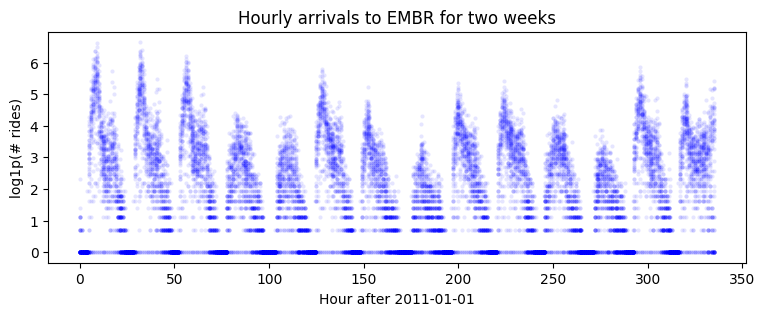

In [3]:
T, O, D = dataset["counts"].shape
data = dataset["counts"][:, :, dataset["stations"].index("EMBR")].log1p()
print(data.shape)
plt.figure(figsize=(9, 3))
plt.plot(data[-24 * 7 * 2:], 'b.', alpha=0.1, markeredgewidth=0)
plt.title("Hourly arrivals to EMBR for two weeks")
plt.ylabel("log1p(# rides)")
plt.xlabel("Hour after 2011-01-01");

Let's try a three-component model with series-local level + series-local seasonality + series-global time-local level. The first two will use variational inference and [plates](); the third will use exact inference with a [GaussianHMM]().

In [4]:
class Model1(ForecastingModel):
    def model(self, zero_data, covariates):
        duration, data_dim = zero_data.shape

        # Let's model each time series as a Levy stable process, and share process parameters
        # across time series. To do that in Pyro, we'll declare the shared random variables
        # outside of the "origin" plate:
        drift_stability = pyro.sample("drift_stability", dist.Uniform(1, 2))
        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-20, 5))
        with pyro.plate("origin", data_dim, dim=-2):
            # Now inside of the origin plate we sample drift and seasonal components.
            # All the time series inside the "origin" plate is conditionally independent,
            # given the drift parameters above.
            with self.time_plate:
                # We combine two different reparameterizers: the inner SymmetricStableReparam
                # is needed for the Stable site, and the outer LocScaleReparam is optional but
                # appears to improve inference.
                with poutine.reparam(config={"drift": LocScaleReparam()}):
                    with poutine.reparam(config={"drift": SymmetricStableReparam()}):
                        drift = pyro.sample("drift",
                                            dist.Stable(drift_stability, 0, drift_scale))

            with pyro.plate("hour_of_week", 24 * 7, dim=-1):
                seasonal = pyro.sample("seasonal", dist.Normal(0, 5))
            
        # Now outside of the time plate we can perform time-dependent operations like
        # integrating over time. This allows us to create a motion with slow drift.
        seasonal = periodic_repeat(seasonal, duration, dim=-1)
        motion = drift.cumsum(dim=-1)  # A Levy stable motion to model shocks.
        prediction = motion + seasonal

        # Next we do some reshaping. Pyro's forecasting framework assumes all data is
        # multivariate of shape (duration, data_dim), but the above code uses an "origins"
        # plate that is left of the time_plate. Our prediction starts off with shape
        assert prediction.shape[-2:] == (data_dim, duration)
        # We need to swap those dimensions but keep the -2 dimension intact, in case Pyro
        # adds sample dimensions to the left of that.
        prediction = prediction.unsqueeze(-1).transpose(-1, -3)
        assert prediction.shape[-3:] == (1, duration, data_dim), prediction.shape

        # Finally we can construct a noise distribution.
        # We will share parameters across all time series.
        obs_scale = pyro.sample("obs_scale", dist.LogNormal(-5, 5))
        noise_dist = dist.Normal(zero_data, obs_scale.unsqueeze(-1))
        self.predict(noise_dist, prediction)

Now let's split data into train and test. This is a bigger dataset, so we'll train on only 90 days of data.

In [5]:
T2 = data.size(-2)    # end
T1 = T2 - 24 * 7 * 2  # train/test split
T0 = T1 - 24 * 90     # beginning: train on 90 days of data
covariates = torch.zeros(data.size(-2), 0)  # empty covariates

In [6]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(Model1(), data[T0:T1], covariates[T0:T1],
                        learning_rate=0.1, num_steps=501, log_every=50)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 705188
INFO 	 step   50 loss = 7.7227
INFO 	 step  100 loss = 3.44737
INFO 	 step  150 loss = 1.98431
INFO 	 step  200 loss = 1.48724
INFO 	 step  250 loss = 1.25238
INFO 	 step  300 loss = 1.18827
INFO 	 step  350 loss = 1.12238
INFO 	 step  400 loss = 1.10252
INFO 	 step  450 loss = 1.07717
INFO 	 step  500 loss = 1.05626


drift_stability = 1.997
drift_scale = 3.863e-08
obs_scale = 0.4636
CPU times: user 30.2 s, sys: 5.29 s, total: 35.5 s
Wall time: 35.2 s


torch.Size([100, 1, 336, 50]) torch.Size([336, 50])


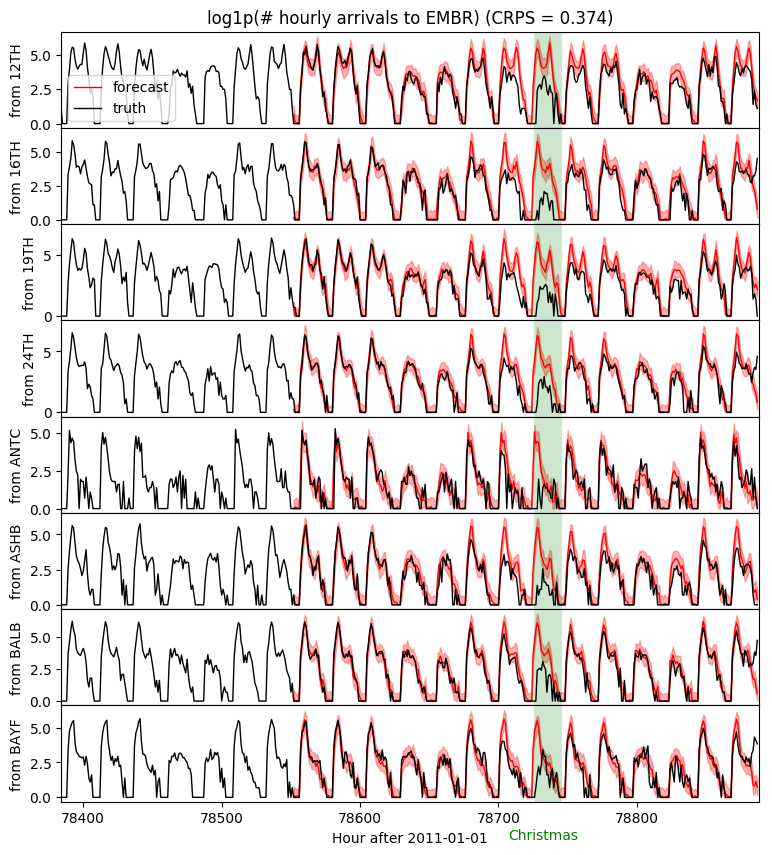

In [7]:
samples = forecaster(data[T0:T1], covariates[T0:T2], num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples[:, 0], (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:T2])
print(samples.shape, p10.shape)

fig, axes = plt.subplots(8, 1, figsize=(9, 10), sharex=True)
plt.subplots_adjust(hspace=0)
axes[0].set_title("log1p(# hourly arrivals to EMBR) (CRPS = {:0.3g})".format(crps))
for i, ax in enumerate(axes):
    ax.axvline(78736, color="green", lw=20, alpha=0.2)
    ax.fill_between(torch.arange(T1, T2), p10[:, i], p90[:, i], color="red", alpha=0.3)
    ax.plot(torch.arange(T1, T2), p50[:, i], 'r-', lw=1, label='forecast')
    ax.plot(torch.arange(T1 - 24 * 7, T2),
            data[T1 - 24 * 7: T2, i], 'k-', lw=1, label='truth')
    ax.set_ylabel("from {}".format(dataset["stations"][i]))
ax.set_xlabel("Hour after 2011-01-01")
ax.text(78732, -3, "Christmas", color="green", horizontalalignment="center")
ax.set_xlim(T1 - 24 * 7, T2)
axes[0].legend(loc="best");

Note the poor predictions on the Christmas holiday. This is to be expected since we only trained on 90 days of data and have not modeled holidays. To accurately forecast holiday behavior we would need to train on multiple years of data, include yearly seasonality components, and ideally include holiday features in covariates.

## Deeper hierarchical models

Next let's consider a larger hierarchy: all 50 x 50 = 2500 pairs of stations. 

In [8]:
data = dataset["counts"].reshape(len(dataset["counts"]), -1).log1p()
print(dataset["counts"].shape, data.shape)

torch.Size([78888, 50, 50]) torch.Size([78888, 2500])


This model will have two levels of hierarchy, each modeled as a [plate](). We can create sample sites in many combinations of plate contexts, allowing many different ways to share statistical strength.

In [52]:
class Model2(ForecastingModel):
    def model(self, zero_data, covariates):
        duration, data_dim = zero_data.shape
        num_stations = int(round(data_dim ** 0.5))
        
        # We construct plates once so we can reuse them later. We ensure they don't collide by
        # specifying different dim args for each: -3, -2, -1. Note the time_plate is dim=-1.
        origin_plate = pyro.plate("origin", num_stations, dim=-3)
        destin_plate = pyro.plate("destin", num_stations, dim=-2)
        hour_of_week_plate = pyro.plate("hour_of_week", 24 * 7, dim=-1)

        # Let's model the time-dependent part with only O(num_stations * duration) many
        # parameters, rather than the full possible O(num_stations ** 1 * duration) data size.
        drift_stability = pyro.sample("drift_stability", dist.Uniform(1, 2))
        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-20, 5))
        with origin_plate:
            with hour_of_week_plate:
                origin_seasonal = pyro.sample("origin_seasonal", dist.Normal(0, 5))
        with destin_plate:
            with hour_of_week_plate:
                destin_seasonal = pyro.sample("destin_seasonal", dist.Normal(0, 5))
            with self.time_plate:
                with poutine.reparam(config={"drift": LocScaleReparam()}):
                    with poutine.reparam(config={"drift": SymmetricStableReparam()}):
                        drift = pyro.sample("drift",
                                            dist.Stable(drift_stability, 0, drift_scale))
        # Additionally we can model a static pairwise station->station affinity, which e.g.
        # can compensate for the fact that people tend not to travel from a station to itself.
        with origin_plate, destin_plate:
            pairwise = pyro.sample("pairwise", dist.Normal(0, 1))

        # Outside of the time plate we can now form the prediction.
        seasonal = origin_seasonal + destin_seasonal  # Note this broadcasts.
        seasonal = periodic_repeat(seasonal, duration, dim=-1)
        motion = drift.cumsum(dim=-1)  # A Levy stable motion to model shocks.
        prediction = motion + seasonal + pairwise

        # We will decompose the noise scale parameter into
        # an origin-local and a destination-local component.
        with origin_plate:
            origin_scale = pyro.sample("origin_scale", dist.LogNormal(-5, 5))
        with destin_plate:
            destin_scale = pyro.sample("destin_scale", dist.LogNormal(-5, 5))
        scale = origin_scale + destin_scale

        # At this point our prediction and scale have shape (50, 50, duration), but we want
        # them to have shape (duration, 50 * 50) to satisfy the Forecaster requirements.
        scale = scale.reshape(scale.shape[:-3] + (1, 1, 1, num_stations ** 2))
        prediction = prediction.reshape(
            prediction.shape[:-3] + (1, 1, num_stations ** 2, duration))
        prediction = prediction.transpose(-1, -2)

        # Finally we construct a noise distribution.
        noise_dist = dist.Normal(zero_data, scale)
        self.predict(noise_dist, prediction)

In [51]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(Model2(), data[T0:T1], covariates[T0:T1],
                        learning_rate=0.1, learning_rate_decay=1, num_steps=501, log_every=50)

INFO 	 step    0 loss = 4.83002e+10
INFO 	 step   50 loss = 133303
INFO 	 step  100 loss = 2.26325
INFO 	 step  150 loss = 0.879171
INFO 	 step  200 loss = 0.926505
INFO 	 step  250 loss = 0.877104
INFO 	 step  300 loss = 1.16108
INFO 	 step  350 loss = 0.699851
INFO 	 step  400 loss = 0.693178
INFO 	 step  450 loss = 0.691856
INFO 	 step  500 loss = 0.694282


CPU times: user 2min 40s, sys: 43.3 s, total: 3min 23s
Wall time: 3min 23s


Now we can forecast forward entire joint samples of every origin-destination pair. The output of `forecast(...)` will have shape `(num_samples, 1, 1, duration, num_stations * num_stations)`. The 1's are placeholders that allow Pyro's `num_samples` plate to avoid conflict with the internal `origin_plate` and `destin_plate` we used in the model.

In [53]:
%%time
samples = forecaster(data[T0:T1], covariates[T0:T2], num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples.reshape(100, T2-T1, 50, 50), (0.1, 0.5, 0.9))
crps = eval_crps(samples, data[T1:T2])
print(samples.shape, p10.shape)

torch.Size([100, 1, 1, 336, 2500]) torch.Size([336, 50, 50])
CPU times: user 23.8 s, sys: 6.79 s, total: 30.6 s
Wall time: 32.8 s


Now we can examine forecasts for any station-station pair. Let's look at Antioch, one of the newer stations with least volume.

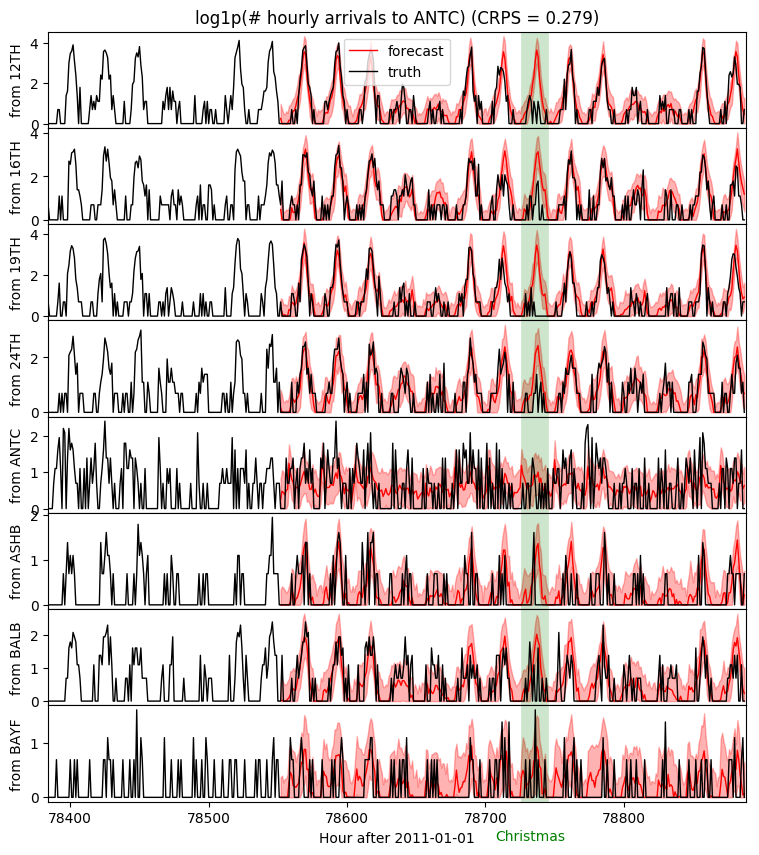

In [56]:
fig, axes = plt.subplots(8, 1, figsize=(9, 10), sharex=True)
plt.subplots_adjust(hspace=0)
j = dataset["stations"].index("ANTC")
axes[0].set_title("log1p(# hourly arrivals to ANTC) (CRPS = {:0.3g})".format(crps))
for i, ax in enumerate(axes):
    ax.axvline(78736, color="green", lw=20, alpha=0.2)
    ax.fill_between(torch.arange(T1, T2), p10[:, i, j], p90[:, i, j], color="red", alpha=0.3)
    ax.plot(torch.arange(T1, T2), p50[:, i, j], 'r-', lw=1, label='forecast')
    ax.plot(torch.arange(T1 - 24 * 7, T2),
            data[T1 - 24 * 7: T2, i * 50 + j], 'k-', lw=1, label='truth')
    ax.set_ylabel("from {}".format(dataset["stations"][i]))
ax.set_xlabel("Hour after 2011-01-01")
ax.text(78732, -0.8, "Christmas", color="green", horizontalalignment="center")
ax.set_xlim(T1 - 24 * 7, T2)
axes[0].legend(loc="best");

Notice that the hierarchy allows the model to make accurate predictions even for very low-volume (station,station) pairs. For example almost nobody rides from Ashby station to Antioch.